### The Golal is to Genarate a ReportCard for Trade Setup -- 20SEP25:09:36:00

In [30]:
import pandas as pd
import mplfinance as mpf

In [31]:
ohlc = pd.read_csv("../Src/xauusdm15.filtered.csv")

ohlc['DateTime'] = pd.to_datetime(ohlc['DateTime'])
ohlc_15M = ohlc.set_index('DateTime')


print(ohlc_15M.head(3))

                         Open      High       Low     Close  Volume
DateTime                                                           
2024-01-01 23:00:00  2064.593  2066.092  2063.301  2065.142      10
2024-01-01 23:15:00  2065.159  2065.900  2064.443  2064.698      15
2024-01-01 23:30:00  2064.664  2065.131  2063.634  2064.258      15


In [32]:
ohlc_4H = ohlc_15M.resample("4h").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()

print(ohlc_4H.head(5))


                         Open      High       Low     Close  Volume
DateTime                                                           
2024-01-01 20:00:00  2064.593  2066.092  2062.643  2063.543      54
2024-01-02 00:00:00  2063.347  2070.338  2062.175  2069.487     240
2024-01-02 04:00:00  2069.492  2076.639  2068.823  2073.065     240
2024-01-02 08:00:00  2073.130  2078.877  2068.247  2069.221     240
2024-01-02 12:00:00  2069.179  2071.018  2056.097  2059.305     240


In [33]:
import logging
import pandas as pd
import mplfinance as mpf
from typing import List, Optional, Dict, Any, Union
from uuid import uuid4
from datetime import datetime

# Configure logging for enterprise use
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('chartter.log')  # Log to file for auditing
    ]
)
logger = logging.getLogger(__name__)

class Chartter:
    """Simple, industry-level financial charting utility using mplfinance for OHLCV data visualization."""

    def __init__(self, config: Optional[Dict[str, Any]] = None):
        """
        Initialize Chartter with default or custom configuration.

        Args:
            config (Dict[str, Any], optional): Custom configuration for charting.
        """
        self._default_config = {
            'chart_type': 'candle',
            'style': 'charles',
            'title': 'Financial Chart',
            'ylabel': 'Price',
            'ylabel_lower': 'Volume',
            'xlabel': 'Date',
            'figratio': (16, 5),
            'panel_ratios': (3, 1),
            'datetime_format': '%Y-%m-%d %H:%M',
            'xrotation': 20,
            'volume': True,  # Toggle to show/hide volume
            'volume_panel': 1,  # Default panel for volume when enabled
            'warn_too_much_data': 10000,
            'width_config': {
                'candle_linewidth': 1.0,
                'candle_width': 0.6,
                'ohlc_linewidth': 1.0,
                'volume_linewidth': 1.0
            },
            'savefig': None  # Path to save chart (e.g., 'chart.png')
        }
        self.config = self._default_config if config is None else {**self._default_config, **config}
        self._validate_config()

    def _validate_config(self) -> None:
        """Validate configuration parameters."""
        valid_chart_types = ['candle', 'ohlc', 'line', 'renko', 'pnf']
        if self.config['chart_type'] not in valid_chart_types:
            logger.error(f"Invalid chart_type: {self.config['chart_type']}. Must be one of {valid_chart_types}")
            raise ValueError(f"chart_type must be one of {valid_chart_types}")

        if not isinstance(self.config['figratio'], tuple) or len(self.config['figratio']) != 2:
            logger.error("figratio must be a tuple of (width, height)")
            raise ValueError("figratio must be a tuple of (width, height)")

        if self.config['savefig'] is not None:
            if not isinstance(self.config['savefig'], str):
                logger.error("savefig must be a string path (e.g., 'chart.png')")
                raise ValueError("savefig must be a string path")
            if not self.config['savefig'].endswith(('.png', '.jpg', '.pdf')):
                logger.error("savefig must have a valid extension (.png, .jpg, .pdf)")
                raise ValueError("savefig must have a valid extension (.png, .jpg, .pdf)")

        if not isinstance(self.config['volume'], bool):
            logger.error("volume must be a boolean (True/False)")
            raise ValueError("volume must be a boolean (True/False)")

        if self.config['volume'] and self.config['volume_panel'] < 0:
            logger.error("volume_panel must be non-negative when volume is True")
            raise ValueError("volume_panel must be non-negative when volume is True")

    def _validate_dataframe(self, df: pd.DataFrame, volume_enabled: bool) -> None:
        """Validate input DataFrame for required OHLCV columns and datetime index."""
        if not isinstance(df, pd.DataFrame):
            logger.error("Input must be a pandas DataFrame")
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = ['Open', 'High', 'Low', 'Close']
        if not all(col in df.columns for col in required_columns):
            logger.error(f"DataFrame must contain columns: {required_columns}")
            raise ValueError(f"DataFrame must contain columns: {required_columns}")

        if not pd.api.types.is_datetime64_any_dtype(df.index):
            logger.error("DataFrame index must be datetime")
            raise ValueError("DataFrame index must be datetime")

        if volume_enabled and 'Volume' not in df.columns:
            logger.error("DataFrame must contain 'Volume' column when volume is True")
            raise ValueError("DataFrame must contain 'Volume' column when volume is True")

        if len(df) > self.config['warn_too_much_data']:
            logger.warning(f"DataFrame contains {len(df)} rows, exceeding warn_too_much_data threshold of {self.config['warn_too_much_data']}")

    def _validate_addplot(self, addplot: Optional[Union[Dict, List[Dict]]], df: pd.DataFrame) -> Optional[List[Dict]]:
        """Validate addplot and ensure data aligns with DataFrame index."""
        if addplot is None:
            return None

        # Convert single dict to list for consistency
        validated_addplot = [addplot] if isinstance(addplot, dict) else addplot
        if not isinstance(validated_addplot, list) or not all(isinstance(item, dict) for item in validated_addplot):
            logger.error("addplot must be a dict or list of dicts")
            raise ValueError("addplot must be a dict or list of dicts")

        # Validate that addplot data aligns with df index
        for ap in validated_addplot:
            if 'data' not in ap:
                continue  # Some addplots (e.g., vlines) may not have 'data'
            ap_data = ap['data']
            if isinstance(ap_data, pd.Series):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            elif isinstance(ap_data, pd.DataFrame):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            else:
                logger.warning("addplot 'data' should be a pandas Series or DataFrame for index validation")

        return validated_addplot

    def plot(
        self,
        df: pd.DataFrame,
        addplot: Optional[Union[Dict, List[Dict]]] = None,
        config: Optional[Dict[str, Any]] = None
    ) -> None:
        """
        Plot financial chart with OHLCV data and optional additional plots.

        Args:
            df (pd.DataFrame): DataFrame with OHLCV data and datetime index.
            addplot (Dict or List[Dict], optional): Additional plots (mpf.make_addplot).
            config (Dict[str, Any], optional): Override default configuration for this plot.

        Raises:
            ValueError: If DataFrame, addplot, or configuration is invalid.
        """
        start_time = datetime.now()
        chart_id = str(uuid4())
        logger.info(f"Generating chart {chart_id} with {len(df)} data points")

        try:
            # Merge custom config with instance config
            plot_config = self.config.copy()
            if config:
                plot_config.update(config)
                self._validate_config()

            # Validate input DataFrame
            self._validate_dataframe(df, volume_enabled=plot_config['volume'])

            # Validate addplot and ensure index alignment
            validated_addplot = self._validate_addplot(addplot, df)

            # Adjust volume_panel and panel_ratios dynamically
            if validated_addplot:
                max_panel = max([ap.get('panel', 0) for ap in validated_addplot], default=0)
                if plot_config['volume']:
                    plot_config['volume_panel'] = max(max_panel + 1, 1)  # Place volume after highest addplot panel
                panel_ratios = tuple([3] + [1] * max(max_panel, plot_config['volume_panel'] if plot_config['volume'] else 0))
            else:
                panel_ratios = (3,) if not plot_config['volume'] else plot_config['panel_ratios']
                if plot_config['volume'] and plot_config['volume_panel'] > 1:
                    plot_config['volume_panel'] = 1  # Reset to avoid missing panels

            # Prepare plot arguments
            plot_kwargs = {
                'type': plot_config['chart_type'],
                'style': plot_config['style'],
                'volume': plot_config['volume'],
                'title': plot_config['title'],
                'ylabel': plot_config['ylabel'],
                'xlabel': plot_config['xlabel'],
                'figratio': plot_config['figratio'],
                'panel_ratios': panel_ratios,
                'tight_layout': True,
                'datetime_format': plot_config['datetime_format'],
                'xrotation': plot_config['xrotation'],
                'warn_too_much_data': plot_config['warn_too_much_data'],
                'update_width_config': plot_config['width_config']
            }

            # Only include volume_panel and ylabel_lower if volume is enabled
            if plot_config['volume']:
                plot_kwargs['volume_panel'] = plot_config['volume_panel']
                plot_kwargs['ylabel_lower'] = plot_config['ylabel_lower']

            # Only include addplot if valid
            if validated_addplot:
                plot_kwargs['addplot'] = validated_addplot

            # Add savefig if specified
            if plot_config['savefig']:
                plot_kwargs['savefig'] = plot_config['savefig']

            # Plot the chart
            mpf.plot(df, **plot_kwargs)
            logger.info(f"Chart {chart_id} generated successfully in {(datetime.now() - start_time).total_seconds():.2f}s")

            # Log file save if applicable
            if plot_config['savefig']:
                logger.info(f"Chart saved to {plot_config['savefig']}")

        except Exception as e:
            logger.error(f"Failed to generate chart {chart_id}: {str(e)}")
            raise

2025-09-21 11:56:09,258 [INFO] Generating chart 8d024370-49d4-4fdf-91dc-3c42d701ffd0 with 151 data points


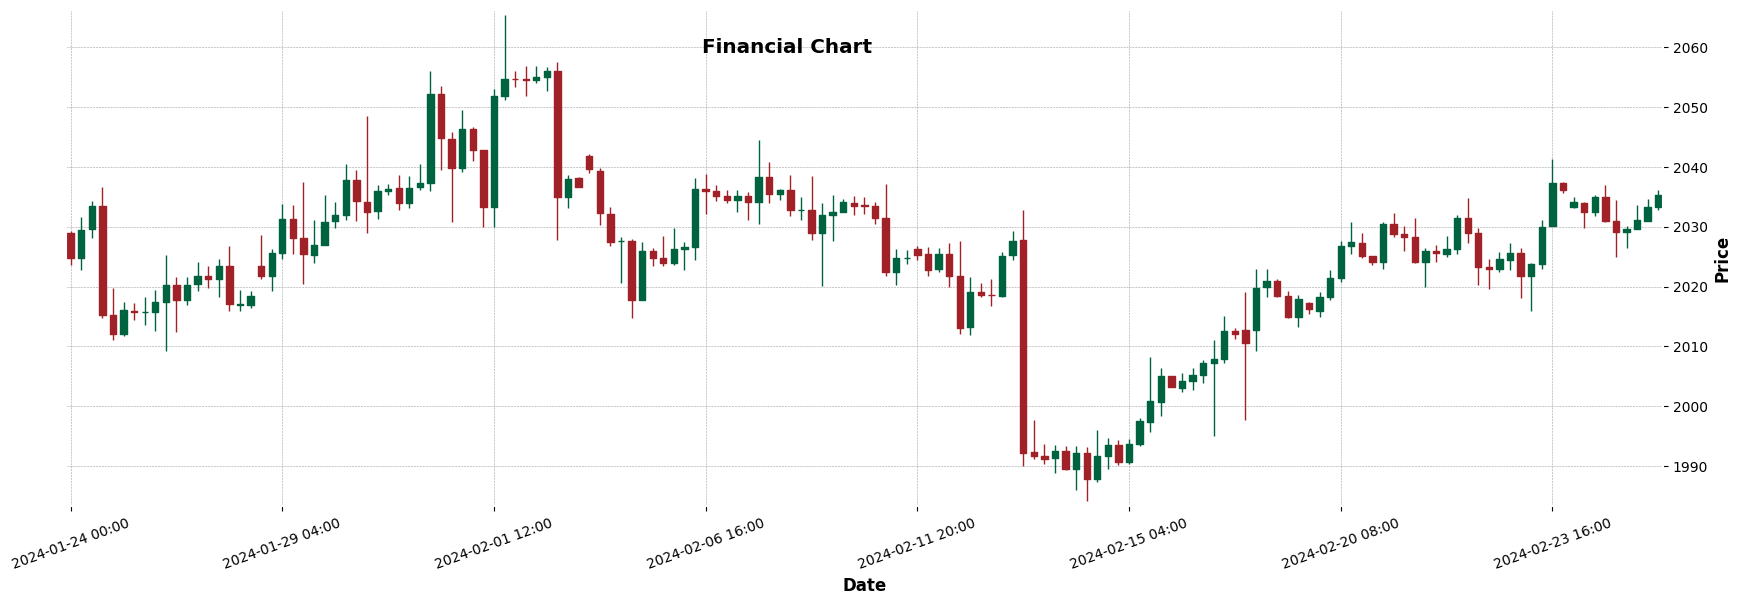

2025-09-21 11:56:15,691 [INFO] Chart 8d024370-49d4-4fdf-91dc-3c42d701ffd0 generated successfully in 6.47s
2025-09-21 11:56:16,034 [INFO] Generating chart 9ccf7231-6c6b-40a3-8847-466689db8a1a with 151 data points


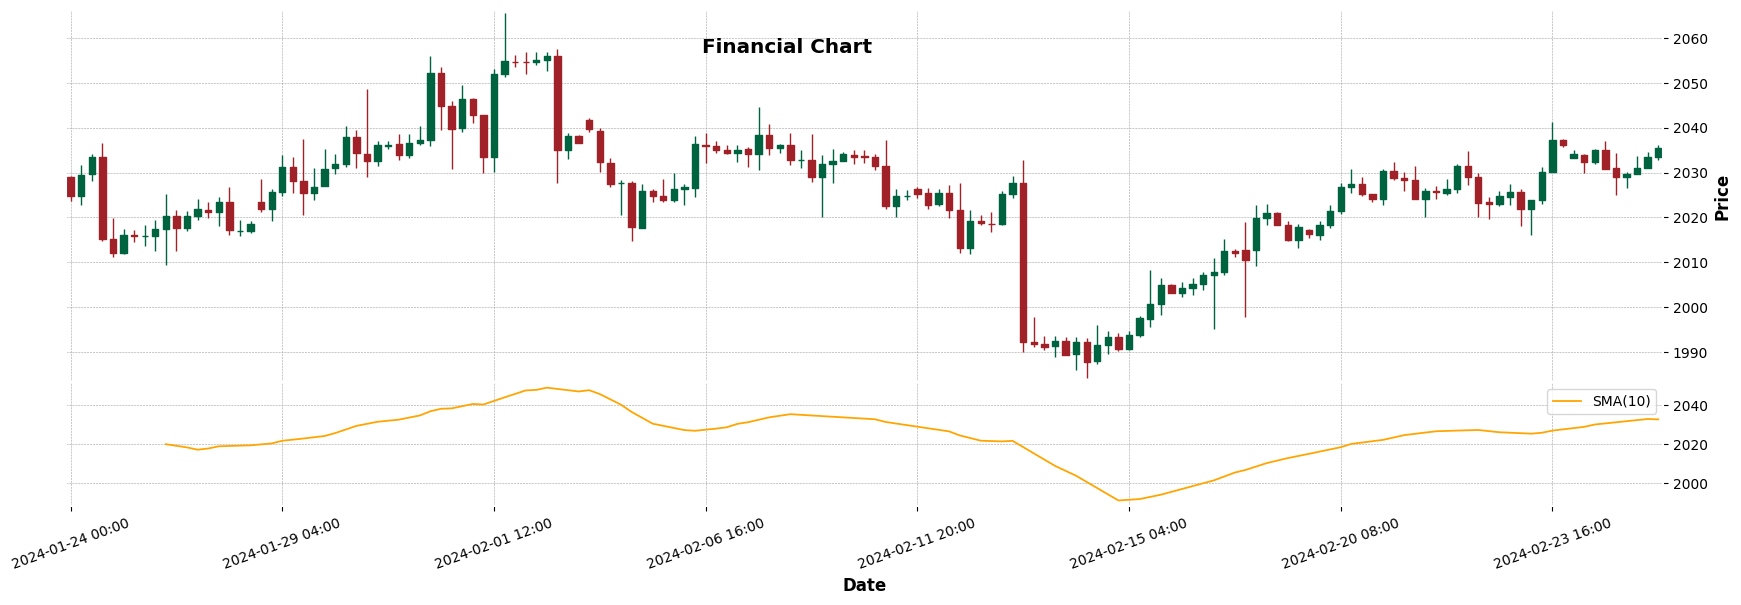

2025-09-21 11:56:18,829 [INFO] Chart 9ccf7231-6c6b-40a3-8847-466689db8a1a generated successfully in 2.80s


In [34]:

# Initialize Chartter with custom config
chartter = Chartter(config={
            # 'chart_type': 'candle',
            # 'style': 'charles',
            'volume': False,
            # 'volume_panel': 1
            # 'savefig': None  # Path to save chart (e.g., 'chart.png')
        })

# Plot without additional plots
chartter.plot(ohlc_4H.iloc[100:251])

# Plot with a custom additional plot, ensuring index alignment

chartter.plot(ohlc_4H.iloc[100:251], addplot=[
    mpf.make_addplot(ohlc_4H.iloc[100:251]['Close'].rolling(10).mean(), color='orange', label='SMA(10)', panel=1)
    ])